In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import altair as alt
import pandas as pd

from glob import glob
from copy import deepcopy
from pypdb import Query, get_pdb_file
from rcsbsearchapi.search import AttributeQuery
from Bio import AlignIO
from anytree import RenderTree
import dist_analy.import_pdb
import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv
from dist_analy.dist_analy import get_shortest_dist_matrix, get_ca_dist_matrix
from dist_analy.tree_analysis import TreeNode
from dist_analy.data_viz import alt_pca_hdbscan_figure, jchart_query, py3Dmol_lig_pose

import prody

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
csv_dict, csv_df = pdb_read_csv("CDK2_pdb.csv", chain=False)
csv_df = csv_df.loc[csv_df.Date < "2023-04-13"]

In [4]:
save_dir = "./datafiles/npy/CDK2_all_res/"
dist_mat_list_0 = []
dist_mat_pdb_0 = []
# for proc_npy in glob(save_dir+'*.npy'):
for pdb in csv_df["PDB ID"]:
    for proc_npy in glob(f"{save_dir}{pdb}_*.npy"):
        pdb_chain = proc_npy.split("/")[-1].split(".")[0]
        dist_mat = np.load(proc_npy)
        dist_mat_list_0.append(dist_mat)
        dist_mat_pdb_0.append(pdb_chain) 

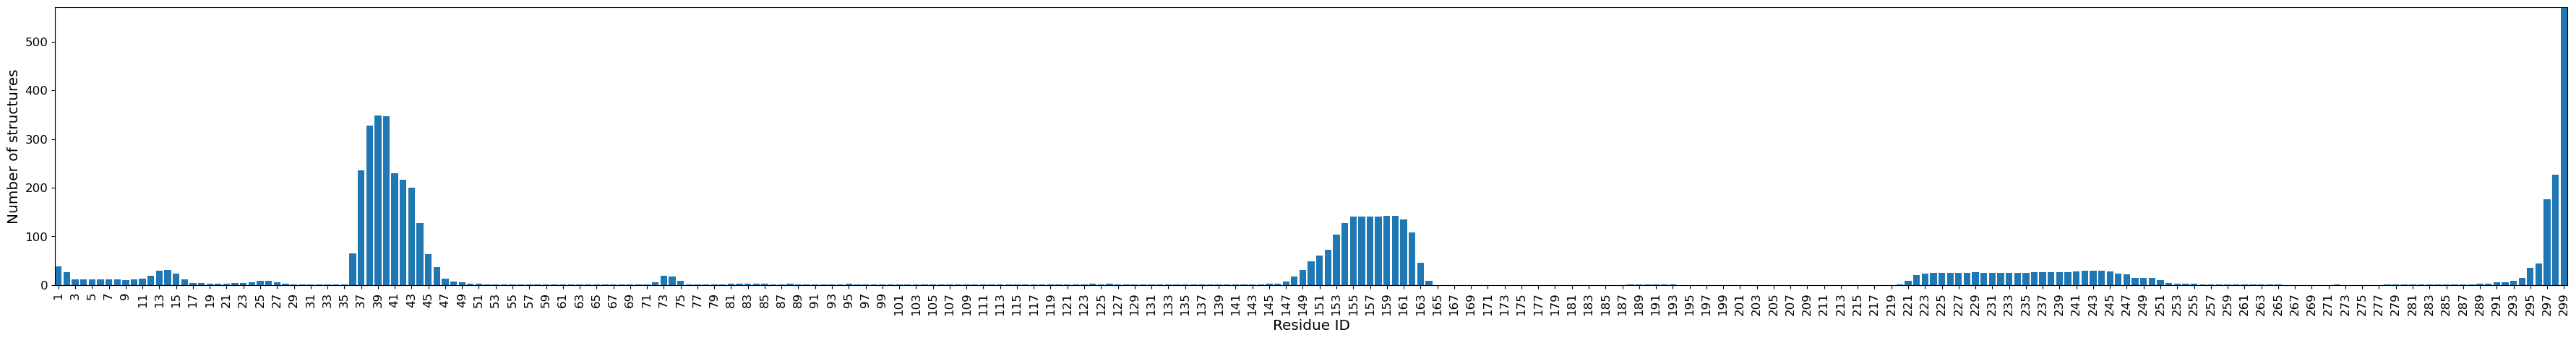

In [5]:
missing_pdb, missing_res = dist_analy.pca.hist_missing_residue(dist_mat_list_0, np.arange(1,300))

pdb structures missing 40 residues: 0 set()


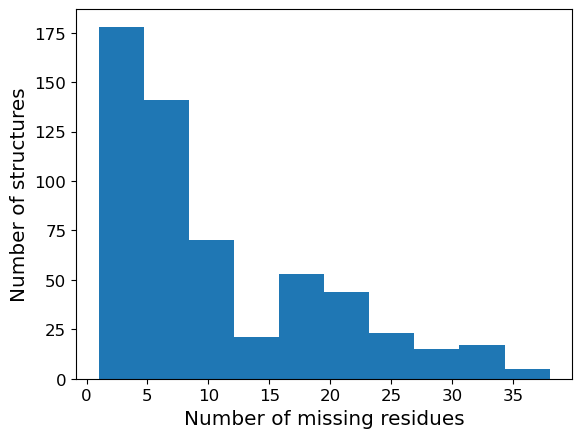

In [22]:
cutoff = 40
missing_fifty = dist_analy.pca.hist_missing_structure(dist_mat_list_0, cutoff = cutoff)
print(f"pdb structures missing {cutoff} residues: {len(missing_fifty)}",set([dist_mat_pdb_0[x] for x in missing_fifty]))

In [7]:
for x in missing_fifty[::-1]:
    del dist_mat_list_0[x]
    del dist_mat_pdb_0[x]

removing residues not available in every structure
original length of residue list 299; remove 123 residues
Cumulative explained variance > 0.75: 0.75, 0.04
0 []
309 ['1AQ1_A' '1B38_A' '1B39_A' '1BUH_A' '1CKP_A' '1DI8_A' '1DM2_A' '1E1V_A'
 '1E1X_A' '1FVT_A' '1G5S_A' '1GIH_A' '1GII_A' '1GIJ_A' '1GZ8_A' '1H00_A'
 '1H01_A' '1H07_A' '1H08_A' '1H0V_A' '1H0W_A' '1HCK_A' '1HCL_A' '1JSV_A'
 '1JVP_P' '1KE5_A' '1KE6_A' '1KE7_A' '1KE8_A' '1KE9_A' '1OIQ_A' '1OIR_A'
 '1OIT_A' '1P2A_A' '1PF8_A' '1PW2_A' '1PXI_A' '1PXJ_A' '1PXK_A' '1PXL_A'
 '1PXM_A' '1PXN_A' '1PXO_A' '1PXP_A' '1PYE_A' '1R78_A' '1URW_A' '1V1K_A'
 '1VYZ_A' '1W0X_C' '1W8C_A' '1WCC_A' '1Y8Y_A' '1Y91_A' '1YKR_A' '2A0C_X'
 '2A4L_A' '2B52_A' '2B53_A' '2B54_A' '2B55_A' '2BHE_A' '2BHH_A' '2BTR_A'
 '2BTS_A' '2C5Y_A' '2C68_A' '2C69_A' '2C6I_A' '2C6K_A' '2C6L_A' '2C6M_A'
 '2C6O_A' '2CLX_A' '2DS1_A' '2DUV_A' '2EXM_A' '2FVD_A' '2J9M_A' '2R3F_A'
 '2R3G_A' '2R3H_A' '2R3I_A' '2R3J_A' '2R3K_A' '2R3L_A' '2R3M_A' '2R3N_A'
 '2R3O_A' '2R3P_A' '2R3Q_A' '2R

/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(
/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(


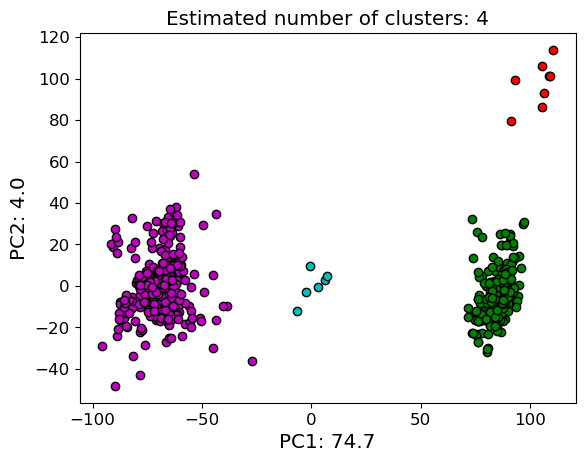

In [23]:
dist_mat_list_0 = np.array(dist_mat_list_0)
proj_coords_0, labels_0, dist_mats_0, res_list_0, ind_list_0, pca_0, hdb_0 = \
        dist_analy.pca.run(dist_mat_list_0, np.arange(1,300), cumsum=0.75, \
                           hdbscan_args={"cluster_selection_epsilon": 10}, \
                           color_list = ['m', 'c', 'g', 'r'])

inds_fc_0 = [[j for j,l in enumerate(labels_0) if l==i ] for i in range(-1,max(labels_0)+1)]
for ind_fc in inds_fc_0:
    print(len(ind_fc), np.asarray(dist_mat_pdb_0)[ind_fc])

# EMA

In [28]:
from prody.proteins.pdbfile import parsePDB

proc_dir = "./datafiles/proc_pdb/CDK2/"
prody_struct = []
for proc in dist_mat_pdb_0:
    pdb = proc.split('.')[0]
    chain = pdb.split("_")[-1]
    prody_struct.append(parsePDB(f"{proc_dir}{proc}.pdb", chain=chain, subset='ca'))

@> 277 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 287 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 279 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 283 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 274 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 296 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 297 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 296 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 288 atoms and 1 coordinate set(s) were parsed in 0.20s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 298 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 296 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 282 atoms and 1 coordinate set(s) were parsed in 0.02

In [36]:
from prody.ensemble.functions import buildPDBEnsemble
ensemble = buildPDBEnsemble(prody_struct, title='CDK2 X-ray', seqid=99, coverage=50)
ensemble.iterpose()

@> Starting iterative superposition:               
@> Step #1: RMSD difference = 1.0007e+00
@> Step #2: RMSD difference = 2.3018e-03
@> Step #3: RMSD difference = 2.4799e-05
@> Iterative superposition completed in 0.20s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.06 seconds.
@> Ensemble (567 conformations) were built in 10.11s.
@> Starting iterative superposition:
@> Step #1: RMSD difference = 3.6147e-07
@> Iterative superposition completed in 0.06s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.06 seconds.


In [62]:
from prody.dynamics.pca import EDA
eda = EDA('CDK2 X-ray')
eda.buildCovariance(ensemble)
eda.calcModes() 

eigv = eda.getEigvals()
evr = eigv/eigv.sum()

@> Covariance is calculated using 567 coordinate sets.
@> Covariance matrix calculated in 0.036722s.
/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/scipy/_lib/deprecation.py:213: DeprecationWarning: Keyword argument 'turbo' is deprecated in favour of 'driver=gvd' keyword instead and will be removed in SciPy 1.14.0.
  return f(*args, **kwargs)
/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/scipy/_lib/deprecation.py:213: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.14.0.
  return f(*args, **kwargs)
@> 20 modes were calculated in 0.05s.


In [38]:
len(prody_struct), len(ensemble), len(dist_mat_pdb_0)

(567, 567, 567)

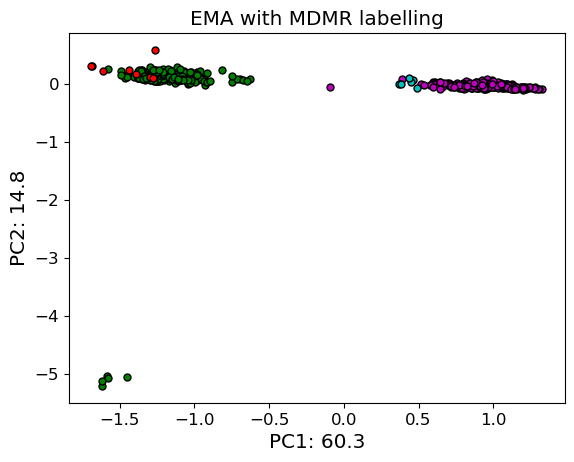

In [86]:
from prody.dynamics.plotting import showProjection

color_list = ['m', 'c', 'g', 'r']

fig = plt.figure()  # Create a new figure
ax = showProjection(ensemble, eda[:2], color=[color_list[i] for i in labels_0], 
                    marker='.', markeredgecolor="k", markersize=10)
plt.xlabel(f"PC1: {evr[0]*100:0.1f}")
plt.ylabel(f"PC2: {evr[1]*100:0.1f}")
plt.title("EMA with MDMR labelling")
plt.show()

0 []
5 ['1W98_A' '5L2W_A' '7KJS_A' '8H6P_A' '8H6T_A']
315 ['1AQ1_A' '1B38_A' '1B39_A' '1BUH_A' '1CKP_A' '1DI8_A' '1DM2_A' '1E1V_A'
 '1E1X_A' '1FVT_A' '1G5S_A' '1GIH_A' '1GII_A' '1GIJ_A' '1GZ8_A' '1H00_A'
 '1H01_A' '1H07_A' '1H08_A' '1H0V_A' '1H0W_A' '1HCK_A' '1HCL_A' '1JSV_A'
 '1JVP_P' '1KE5_A' '1KE6_A' '1KE7_A' '1KE8_A' '1KE9_A' '1OIQ_A' '1OIR_A'
 '1OIT_A' '1P2A_A' '1PF8_A' '1PW2_A' '1PXI_A' '1PXJ_A' '1PXK_A' '1PXL_A'
 '1PXM_A' '1PXN_A' '1PXO_A' '1PXP_A' '1PYE_A' '1R78_A' '1URW_A' '1V1K_A'
 '1VYZ_A' '1W0X_C' '1W8C_A' '1WCC_A' '1Y8Y_A' '1Y91_A' '1YKR_A' '2A0C_X'
 '2A4L_A' '2B52_A' '2B53_A' '2B54_A' '2B55_A' '2BHE_A' '2BHH_A' '2BTR_A'
 '2BTS_A' '2C5Y_A' '2C68_A' '2C69_A' '2C6I_A' '2C6K_A' '2C6L_A' '2C6M_A'
 '2C6O_A' '2CLX_A' '2DS1_A' '2DUV_A' '2EXM_A' '2FVD_A' '2J9M_A' '2R3F_A'
 '2R3G_A' '2R3H_A' '2R3I_A' '2R3J_A' '2R3K_A' '2R3L_A' '2R3M_A' '2R3N_A'
 '2R3O_A' '2R3P_A' '2R3Q_A' '2R3R_A' '2R64_A' '2UZN_A' '2UZO_A' '2V0D_A'
 '2VTA_A' '2VTH_A' '2VTI_A' '2VTJ_A' '2VTL_A' '2VTM_A' '2VTN_A' '2

/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(
/Users/ericchen/opt/anaconda3/envs/dist_analy.publish/lib/python3.9/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:821: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.labels_, self.probabilities_ = tree_to_labels(


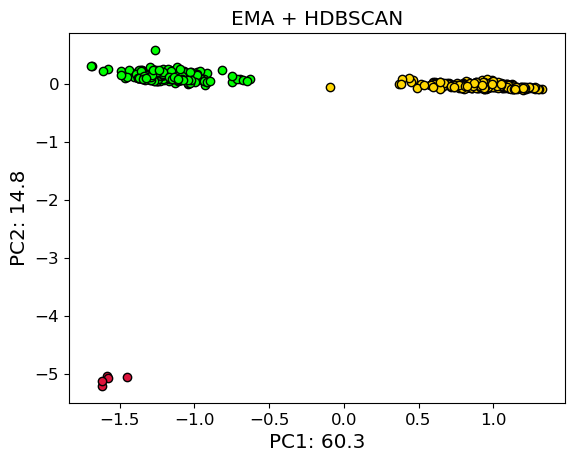

In [91]:
from prody.dynamics.analysis import calcProjection

cumsum = 0.75

sel_axis = np.where(np.cumsum(evr) < cumsum)[0]
if len(sel_axis) < 2:
    sel_axis=[0,1]
a = calcProjection(ensemble, eda[sel_axis])

color_list = ['crimson', 'gold', 'lime',]
labels_eda, hdb_eda = dist_analy.pca.pca_hdbscan(a[:,:2], evr[:2], 
                                         hdbscan_args={"cluster_selection_epsilon": 0.2},
                                         color_list=color_list)
# plt.scatter(a[:,0], a[:,1])
plt.title("EMA + HDBSCAN")

inds_fc_eda = [[j for j,l in enumerate(labels_eda) if l==i ] for i in range(-1,max(labels_eda)+1)]
for ind_fc in inds_fc_eda:
    print(len(ind_fc), np.asarray(dist_mat_pdb_0)[ind_fc])